# Vision por Computadora I - CEIA

## Trabajo Practico N° 4

#### Autor: Juan Ignacio Ribet

▪ Implementar el detector de fondo naive usando la mediana como
estimador. El algoritmo debe recibir el parámetro N (cantidad de
frames utilizados para la estimación) y el intervalo de tiempo para
recalcular el fondo.

▪ Se deben generar las mascaras de foreground y aplicarlas a los frames
para segmentar los objetos en movimiento.

▪ Comparar con alguno de los métodos vistos en la practica basados en
mezcla de gaussianas

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Punto 1:
▪ Implementar el detector de fondo naive usando la mediana como
estimador. El algoritmo debe recibir el parámetro N (cantidad de
frames utilizados para la estimación) y el intervalo de tiempo para
recalcular el fondo.

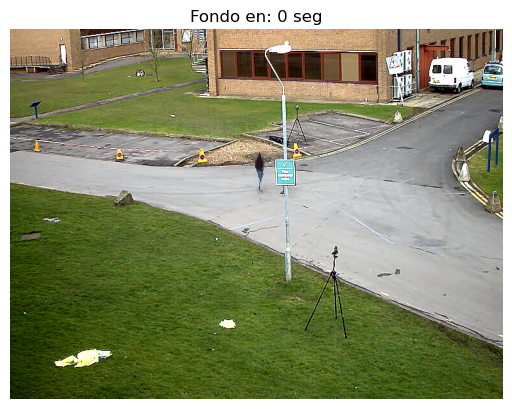

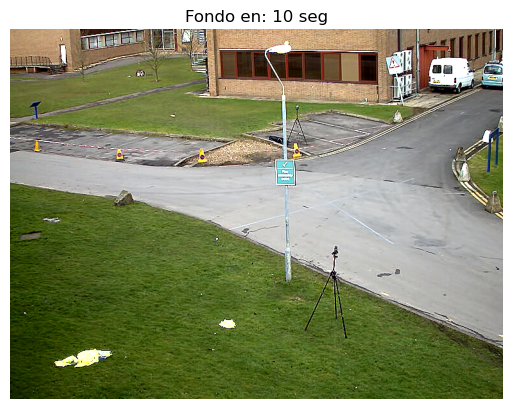

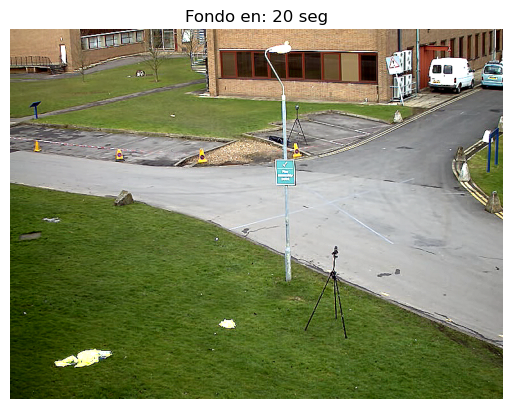

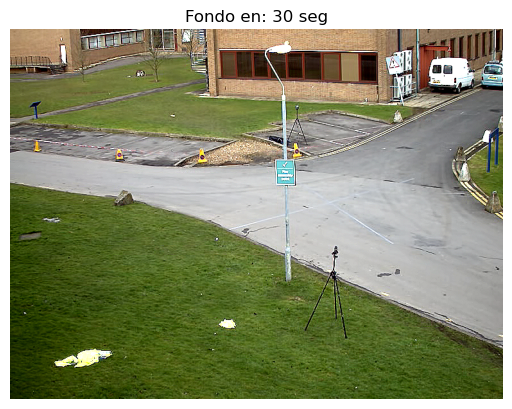

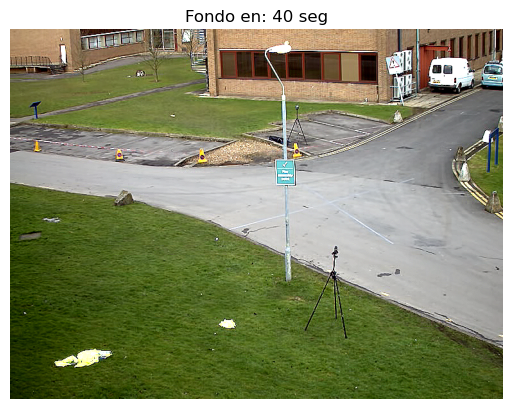

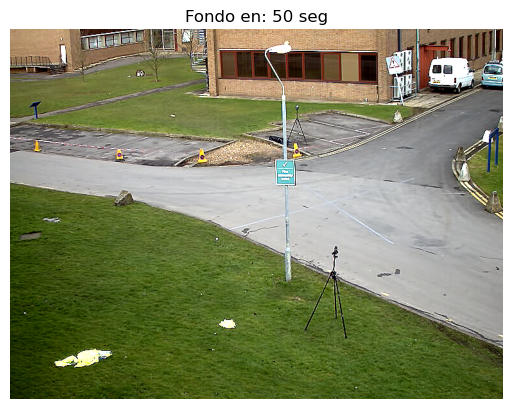

In [187]:
cap = cv.VideoCapture('vtest.avi')
frames = [] # Lista de frames para calcular la mediana

N = 200 # cantidad de frames utilizados para la estimación
time = 10 #intervalo de tiempo para recalcular el fondo

fps = cap.get(cv.CAP_PROP_FPS)
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

inicio = 1 # Frame inicial para calcular el fondo
frames_time = time*int(fps) # Frames en el intervalo de tiempo

while cap.isOpened():
    
    success, image = cap.read()
    if image is None:
        break

    # Agrego las imagenes a las lista de frames para luego calcular la mediana
    if inicio < int(cap.get(cv.CAP_PROP_POS_FRAMES)) <= inicio+N:
        frames.append(image)

    # Proceso la imagen luego de intervalo de tiempo establesido
    if int(cap.get(cv.CAP_PROP_POS_FRAMES)) == inicio+N:
        fondo = np.median(frames, axis=0).astype(dtype=np.uint8)
        # Mejoro la imagen
        kernel = np.array([[0,-1,0],
                        [-1,5,-1],
                        [0,-1,0]])
        fondo2 = cv.filter2D(fondo, ddepth=-1, kernel=kernel)

        plt.title(f'Fondo en: {int(inicio/int(fps))} seg'); plt.axis('off');plt.imshow(fondo2[:,:,::-1]);plt.show()

        # Seteo el nuevo inicio de toma de imagenes
        inicio = inicio+frames_time

    cv.imshow('video', image)
    
    if cv.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


## Punto 2:

▪ Se deben generar las mascaras de foreground y aplicarlas a los frames
para segmentar los objetos en movimiento.

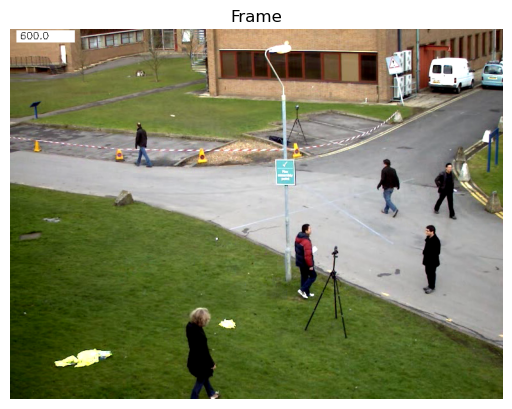

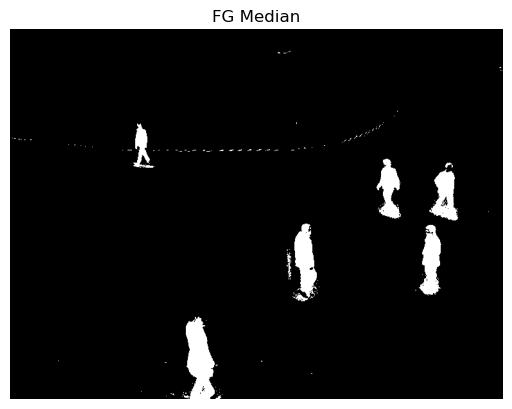

In [206]:
cap = cv.VideoCapture('vtest.avi')

# Transformo el fondo a gris
fondo_gray = cv.cvtColor(fondo, cv.COLOR_BGR2GRAY)

while cap.isOpened():
    
    success, image = cap.read()

    if image is None:
        break
    
    # Transformo el frame a gris
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    #Se resta el frame actual con la mediana
    image_seg = cv.subtract(fondo_gray,img_gray)

    # Binarizo 
    ret,image_seg = cv.threshold(image_seg,20,255,cv.THRESH_BINARY)

    # Escribimos sobre la imagen el número de frame procesado
    cv.rectangle(image, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(image, str(cap.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    # Muestro en pantalla un frame random (180)
    if int(cap.get(cv.CAP_PROP_POS_FRAMES)) == 600:
        plt.title('Frame'); plt.axis('off');plt.imshow(image[:,:,::-1]);plt.show()
        plt.title('FG Median'); plt.axis('off');plt.imshow(image_seg, cmap='gray');plt.show()

    cv.imshow('Frame', image)
    cv.imshow('FG Median', image_seg)
    
    if cv.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


## Punto 3:
▪ Comparar con alguno de los métodos vistos en la practica basados en
mezcla de gaussianas

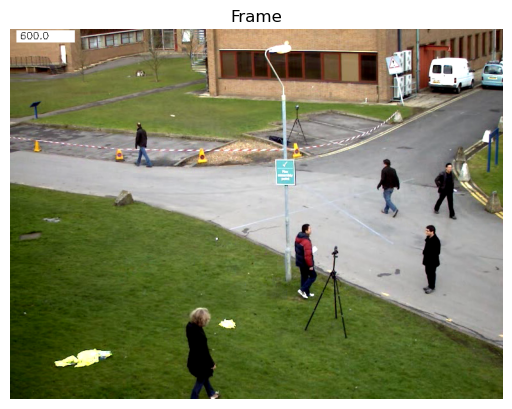

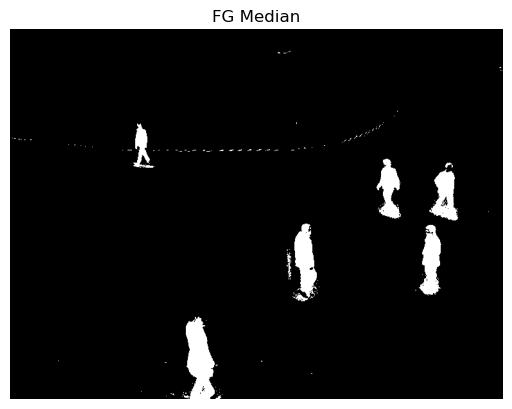

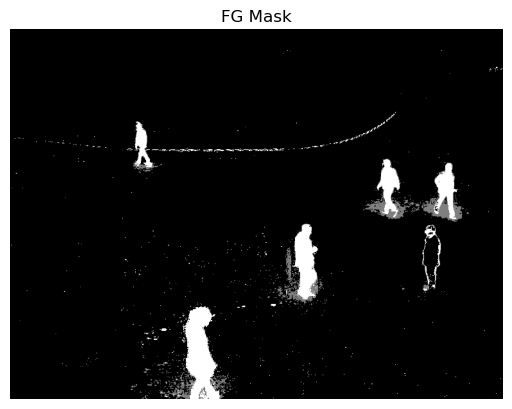

In [207]:
cap = cv.VideoCapture('vtest.avi')

# Transformo el fondo a gris
fondo_gray = cv.cvtColor(fondo, cv.COLOR_BGR2GRAY)

# Comparo con el metodo MOG
backSub = cv.createBackgroundSubtractorMOG2()

while cap.isOpened():
    
    success, image = cap.read()

    if image is None:
        break
    
    # Aplico el metodo del punto 2
    img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_seg = cv.subtract(fondo_gray,img_gray)
    ret,image_seg = cv.threshold(image_seg,20,255,cv.THRESH_BINARY)

    # Aplicamos la sustracción al frame leído
    fgMask = backSub.apply(image)
    
    # Escribimos sobre la imagen el número de frame procesado
    cv.rectangle(image, (10, 2), (100,20), (255,255,255), -1)
    cv.putText(image, str(cap.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
               cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
    
    # Muestro en pantalla un frame random (600)
    if int(cap.get(cv.CAP_PROP_POS_FRAMES)) == 600: 
        plt.title('Frame'); plt.axis('off');plt.imshow(image[:,:,::-1]);plt.show()
        plt.title('FG Median'); plt.axis('off');plt.imshow(image_seg, cmap='gray');plt.show()
        plt.title('FG Mask'); plt.axis('off');plt.imshow(fgMask, cmap='gray');plt.show()


    cv.imshow('Frame', image)
    cv.imshow('FG Median', image_seg)
    cv.imshow('FG Mask', fgMask)
    
    if cv.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()